In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bilal1907/mimic-iii-10k")

print("Path to dataset files:", path)

100%|██████████| 1.12G/1.12G [00:13<00:00, 87.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bilal1907/mimic-iii-10k/versions/1


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
# import os
# import pandas as pd

# drive.mount('/content/drive')

# base_dir = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)"

# for root, dirs, files in os.walk(base_dir):
#     for file in files:
#         print(os.path.join(root, file))


In [18]:
import pandas as pd

admissions_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/ADMISSIONS/ADMISSIONS_random.csv"
patients_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/PATIENTS/PATIENTS_random.csv"
icustays_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/ICUSTAYS/ICUSTAYS_random.csv"
diagnoses_icd_csv = r"/content/drive/MyDrive/Colab Notebooks/MIMIC -III (10000 patients)/DIAGNOSES_ICD/DIAGNOSES_ICD_random.csv"



In [19]:
# Load data
admissions_df = pd.read_csv(admissions_csv)
patients_df = pd.read_csv(patients_csv)
icustays_df = pd.read_csv(icustays_csv)
diagnoses_icd_df = pd.read_csv(diagnoses_icd_csv)

# --- Merge Data ---

# 1. Merge ADMISSIONS and PATIENTS on SUBJECT_ID
adm_patients_df = pd.merge(admissions_df, patients_df, on="SUBJECT_ID", how="inner")

# 2. Merge the result with ICUSTAYS on SUBJECT_ID and HADM_ID
merged_df = pd.merge(adm_patients_df, icustays_df, on=["SUBJECT_ID", "HADM_ID"], how="inner")

# 3. Aggregate DIAGNOSES_ICD: Count number of diagnoses per admission (HADM_ID)
diagnoses_agg = diagnoses_icd_df.groupby("HADM_ID")["ICD9_CODE"].count().reset_index()
diagnoses_agg.rename(columns={"ICD9_CODE": "num_diagnoses"}, inplace=True)

# 4. Merge diagnoses counts into the main dataframe on HADM_ID
merged_df = pd.merge(merged_df, diagnoses_agg, on="HADM_ID", how="left")



In [20]:
import pandas as pd
import numpy as np

# Convert to datetime safely; invalid parsing will result in NaT
merged_df['ADMITTIME'] = pd.to_datetime(merged_df['ADMITTIME'], errors='coerce')
merged_df['DOB'] = pd.to_datetime(merged_df['DOB'], errors='coerce')

# Drop rows where ADMITTIME or DOB is missing
merged_df = merged_df.dropna(subset=['ADMITTIME', 'DOB'])

def safe_age(row):
    try:
        # Calculate the difference in days
        diff_days = (row['ADMITTIME'] - row['DOB']).days
    except Exception:
        return np.nan
    # Filter out implausible differences
    if diff_days < 0 or diff_days > 120 * 365.25:
        return np.nan
    return diff_days / 365.25

# Apply the safe_age function row-wise
merged_df['Age'] = merged_df.apply(safe_age, axis=1)

# Drop any rows with NaN Age after calculation
merged_df = merged_df.dropna(subset=['Age'])

# Check the resulting ages
print(merged_df[['ADMITTIME', 'DOB', 'Age']].head())



            ADMITTIME        DOB        Age
0 2171-08-20 11:26:00 2098-08-03  73.043121
1 2119-08-25 22:37:00 2058-01-29  61.566051
2 2120-09-17 05:03:00 2058-01-29  62.631075
3 2125-03-01 23:19:00 2058-01-29  67.082820
4 2126-03-11 23:06:00 2058-01-29  68.109514


In [21]:
merged_df

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,num_diagnoses,Age
0,435,342,193432,2171-08-20 11:26:00,2171-08-30 16:35:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,carevue,MICU,MICU,12,12,2171-08-20 11:28:54,2171-08-22 17:20:01,2.2438,NaN,73.043121
1,518,406,113900,2119-08-25 22:37:00,2119-09-01 18:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Medicaid,...,carevue,MICU,MICU,15,15,2119-08-25 22:38:07,2119-08-28 18:40:47,2.8352,NaN,61.566051
2,519,406,171178,2120-09-17 05:03:00,2120-09-28 12:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicaid,...,carevue,MICU,MICU,52,52,2120-09-17 05:04:59,2120-09-20 18:42:54,3.5680,NaN,62.631075
3,520,406,123423,2125-03-01 23:19:00,2125-03-07 20:25:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,...,metavision,MICU,MICU,50,50,2125-03-01 23:20:36,2125-03-03 17:47:34,1.7687,NaN,67.082820
4,521,406,100765,2126-03-11 23:06:00,2126-03-26 16:17:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Medicare,...,metavision,MICU,CCU,50,7,2126-03-11 23:07:15,2126-03-18 22:17:14,6.9653,NaN,68.109514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,57140,94293,172466,2103-12-30 20:14:00,2104-01-23 16:29:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,metavision,MICU,MICU,52,52,2104-01-10 12:41:02,2104-01-14 15:43:50,4.1269,NaN,74.647502
610,57933,96703,143513,2118-03-02 18:52:00,2118-03-07 14:25:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,OTHER FACILITY,Medicare,...,metavision,MICU,MICU,50,50,2118-03-02 18:52:56,2118-03-03 17:04:38,0.9248,NaN,50.277892
611,56385,91881,184208,2132-09-30 15:53:00,2132-10-05 14:05:00,2132-10-05 14:05:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Medicare,...,metavision,SICU,SICU,33,33,2132-10-02 03:08:33,2132-10-05 16:50:41,3.5709,NaN,84.254620
612,56889,93557,170495,2140-04-01 23:14:00,2140-04-28 14:10:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LONG TERM CARE HOSPITAL,Medicaid,...,metavision,SICU,SICU,57,57,2140-04-01 23:14:31,2140-04-20 16:57:13,18.7380,24.0,42.050650


In [22]:
import pandas as pd
import numpy as np

# --- Assume merged_df already exists from your merging pipeline ---
# If not, re-run your merging code to obtain merged_df

# Ensure ADMITTIME and DISCHTIME are datetime and compute LOS_hours if missing
merged_df['ADMITTIME'] = pd.to_datetime(merged_df['ADMITTIME'], errors='coerce')
merged_df['DISCHTIME'] = pd.to_datetime(merged_df['DISCHTIME'], errors='coerce')
if 'LOS_hours' not in merged_df.columns:
    merged_df['LOS_hours'] = (merged_df['DISCHTIME'] - merged_df['ADMITTIME']).dt.total_seconds() / 3600

# Ensure mortality column exists (derived from HOSPITAL_EXPIRE_FLAG)
if 'mortality' not in merged_df.columns:
    merged_df['mortality'] = merged_df['HOSPITAL_EXPIRE_FLAG']

# Now, ensure DOB is converted to datetime
merged_df['DOB'] = pd.to_datetime(merged_df['DOB'], errors='coerce')

# Drop rows with missing ADMITTIME, DISCHTIME, DOB, LOS_hours, or mortality as needed
merged_df = merged_df.dropna(subset=['ADMITTIME', 'DISCHTIME', 'DOB', 'LOS_hours', 'mortality'])

# Define a safe function to compute Age
def safe_age(row):
    try:
        diff = (row['ADMITTIME'] - row['DOB']).days
    except Exception:
        return np.nan
    # Filter out implausible values: negative age or > 120 years
    if diff < 0 or diff > 120 * 365.25:
        return np.nan
    return diff / 365.25

# Compute Age row-by-row using the safe function
merged_df['Age'] = merged_df.apply(safe_age, axis=1)
merged_df = merged_df.dropna(subset=['Age'])

# Now, select a subset of columns as our modeling dataset
final_features = [
    "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "Age", "GENDER", "ETHNICITY",
    "ADMISSION_TYPE", "LOS_hours", "num_diagnoses", "mortality"
]

final_df = merged_df[final_features].copy()

# Display a sample of the final merged dataset
# print()
final_df

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,Age,GENDER,ETHNICITY,ADMISSION_TYPE,LOS_hours,num_diagnoses,mortality
0,342,193432,203303,73.043121,F,BLACK/AFRICAN AMERICAN,EMERGENCY,245.150000,NaN,0
1,406,113900,234844,61.566051,F,WHITE,EMERGENCY,163.383333,NaN,0
2,406,171178,285461,62.631075,F,WHITE,EMERGENCY,271.200000,NaN,0
3,406,123423,252268,67.082820,F,WHITE,EMERGENCY,141.100000,NaN,0
4,406,100765,231758,68.109514,F,WHITE,EMERGENCY,353.183333,NaN,0
...,...,...,...,...,...,...,...,...,...,...
609,94293,172466,250520,74.647502,F,WHITE,EMERGENCY,572.250000,NaN,0
610,96703,143513,227096,50.277892,M,WHITE,EMERGENCY,115.550000,NaN,0
611,91881,184208,236973,84.254620,M,WHITE,ELECTIVE,118.200000,NaN,1
612,93557,170495,281513,42.050650,M,WHITE,EMERGENCY,638.933333,24.0,0


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Assuming final_df is your merged dataset with columns:
# "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "Age", "GENDER", "ETHNICITY",
# "ADMISSION_TYPE", "LOS_hours", "num_diagnoses", "mortality"

# Drop identifier columns that are not useful for modeling
model_df = final_df.drop(columns=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])

# Handle categorical variables:
# For example, use one-hot encoding for GENDER, ETHNICITY, and ADMISSION_TYPE
model_df = pd.get_dummies(model_df, columns=["GENDER", "ETHNICITY", "ADMISSION_TYPE"], drop_first=True)

# Define features (X) and target (y)
X = model_df.drop(columns=["mortality"])
y = model_df["mortality"]

# Split the data into training and testing sets (80-20 split, stratify if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Initialize and train the XGBoost classifier
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print("XGBoost Accuracy: {:.4f}".format(accuracy))
print("XGBoost AUROC: {:.4f}".format(auc))
print("\nClassification Report:\n", report)

# Optional: Feature importance
import matplotlib.pyplot as plt

# Plot feature importance
xgb_importances = xgb_model.feature_importances_
features = X.columns


XGBoost Accuracy: 0.9237
XGBoost AUROC: 0.9127

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       106
           1       0.80      0.33      0.47        12

    accuracy                           0.92       118
   macro avg       0.86      0.66      0.71       118
weighted avg       0.92      0.92      0.91       118



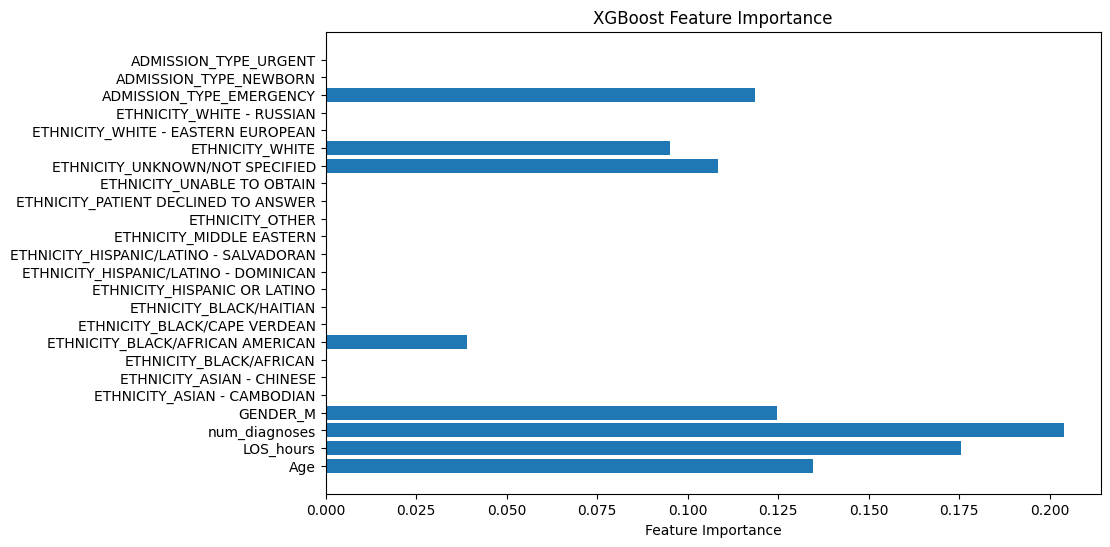

In [24]:

plt.figure(figsize=(10, 6))
plt.barh(features, xgb_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8476 - loss: 1.2646 - val_accuracy: 0.9149 - val_loss: 1.5123
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8379 - loss: 2.3207 - val_accuracy: 0.9149 - val_loss: 0.3975
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7181 - loss: 1.6995 - val_accuracy: 0.9255 - val_loss: 0.5267
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.8904 - val_accuracy: 0.9255 - val_loss: 0.5821
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8855 - loss: 0.5866 - val_accuracy: 0.9255 - val_loss: 0.4857
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8795 - loss: 0.6396 - val_accuracy: 0.9255 - val_loss: 0.5445
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8276 - loss: 0.8889 - val_accuracy: 0.9255 - val_loss: 0.4418
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8659 - loss: 1.0055 - val_accuracy: 0.9255 - val

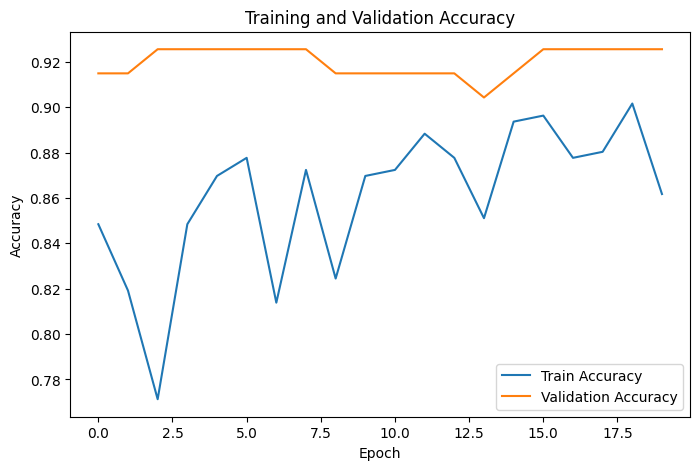

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# --- Preprocessing ---
# Assume final_df is your merged dataset with columns:
# "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "Age", "GENDER", "ETHNICITY",
# "ADMISSION_TYPE", "LOS_hours", "num_diagnoses", "mortality"

# Drop identifier columns
model_df = final_df.drop(columns=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])

# One-hot encode categorical variables: GENDER, ETHNICITY, ADMISSION_TYPE
model_df = pd.get_dummies(model_df, columns=["GENDER", "ETHNICITY", "ADMISSION_TYPE"], drop_first=True)

# Define features (X) and target (y)
X = model_df.drop(columns=["mortality"])
y = model_df["mortality"]

# Fill missing values in features
X = X.fillna(0)

# Optionally, normalize features (uncomment if needed)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training and testing sets (80-20 split; stratify to preserve target distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Build the DNN Model ---
model = Sequential()
# Instead of using input_dim, use an Input layer for clarity
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # output layer for binary classification

# Compile the model with binary crossentropy loss and adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model; validation_split reserves 20% of the training data for validation
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# --- Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.4f}".format(accuracy))

# Generate predicted probabilities and binary predictions
y_prob = model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Plot Training History ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
